In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix
from scripts_tempHelix import generate_static_temporal_helix

In [2]:
def estimate_hitting_time(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_static_temporal_helix(rep))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49 or s==59 or s==69 or s==79 or s==89 or s==99:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def theoretical_hitting_time(n,factor,c):
    hitting_times = []
    for i in n:
        hitting_times.append(c*i**factor)
       
    return hitting_times

In [55]:
reps = 150

sum_range = []
samples = 200

sum_range = [3 + 3*rep for rep in range(1,reps)]
print(sum_range)

initVertex = 0
targetVertex = -1

factor = 2
c = 0.85

hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeStaticTempHelix_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = theoretical_hitting_time(sum_range,factor,c)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times = estimate_hitting_time(reps,initVertex,targetVertex,samples)
    theoretical_hitting_times = theoretical_hitting_time(sum_range,factor,c)

    write_list_to_file(hitting_times_file, hitting_times)



[6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111, 114, 117, 120, 123, 126, 129, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165, 168, 171, 174, 177, 180, 183, 186, 189, 192, 195, 198, 201, 204, 207, 210, 213, 216, 219, 222, 225, 228, 231, 234, 237, 240, 243, 246, 249, 252, 255, 258, 261, 264, 267, 270, 273, 276, 279, 282, 285, 288, 291, 294, 297, 300, 303, 306, 309, 312, 315, 318, 321, 324, 327, 330, 333, 336, 339, 342, 345, 348, 351, 354, 357, 360, 363, 366, 369, 372, 375, 378, 381, 384, 387, 390, 393, 396, 399, 402, 405, 408, 411, 414, 417, 420, 423, 426, 429, 432, 435, 438, 441, 444, 447, 450]
Looking for: 
-----> Datasets/DynGraphsDTRW/hittingTimeStaticTempHelix_N450_FROM0-TO-1_S200.txt

File Doesnt Exist!

Calculatig hitting time for reps = 1 ; n = 6
Starting node: 0 	 Neighbors: [0, 1]
End node: 5 	 Neighbors: [4, 5]
----> Sample number:0
----> Sample number:1
----> Sample 

----> Sample number:99

Calculatig hitting time for reps = 21 ; n = 66
Starting node: 0 	 Neighbors: [0, 1]
End node: 65 	 Neighbors: [64, 65]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 22 ; n = 69
Starting node: 0 	 Neighbors: [0, 1]
End node: 68 	 Neighbors: [67, 68]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 23 ; n = 72
Starting node: 0 	 Neighbors: [0, 1]
End node: 71 	 Neighbors: [70, 71]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
--

----> Sample number:99

Calculatig hitting time for reps = 43 ; n = 132
Starting node: 0 	 Neighbors: [0, 1]
End node: 131 	 Neighbors: [130, 131]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 44 ; n = 135
Starting node: 0 	 Neighbors: [0, 1]
End node: 134 	 Neighbors: [133, 134]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 45 ; n = 138
Starting node: 0 	 Neighbors: [0, 1]
End node: 137 	 Neighbors: [136, 137]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample 

----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 65 ; n = 198
Starting node: 0 	 Neighbors: [0, 1]
End node: 197 	 Neighbors: [196, 197]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 66 ; n = 201
Starting node: 0 	 Neighbors: [0, 1]
End node: 200 	 Neighbors: [199, 200]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 67 ; n = 204
Starting node: 0 	 Neighbors: [0, 1]
End node: 203 	 Neighbors: [202, 203]
----> Sample number:0
----> Sample number:1
----> Sample 

----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 87 ; n = 264
Starting node: 0 	 Neighbors: [0, 1]
End node: 263 	 Neighbors: [262, 263]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 88 ; n = 267
Starting node: 0 	 Neighbors: [0, 1]
End node: 266 	 Neighbors: [265, 266]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 89 ; n = 270
Starting node: 0 	 Neighbors: [0, 1]
End node: 269 	 Neighbors: [268, 269]
----> Sampl

----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 109 ; n = 330
Starting node: 0 	 Neighbors: [0, 1]
End node: 329 	 Neighbors: [328, 329]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 110 ; n = 333
Starting node: 0 	 Neighbors: [0, 1]
End node: 332 	 Neighbors: [331, 332]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 111 ; n = 336
Starting node: 0 	 Neighbors: [0, 1]


----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 131 ; n = 396
Starting node: 0 	 Neighbors: [0, 1]
End node: 395 	 Neighbors: [394, 395]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting time for reps = 132 ; n = 399
Starting node: 0 	 Neighbors: [0, 1]
End node: 398 	 Neighbors: [397, 398]
----> Sample number:0
----> Sample number:1
----> Sample number:10
----> Sample number:25
----> Sample number:35
----> Sample number:49
----> Sample number:59
----> Sample number:69
----> Sample number:79
----> Sample number:89
----> Sample number:99

Calculatig hitting

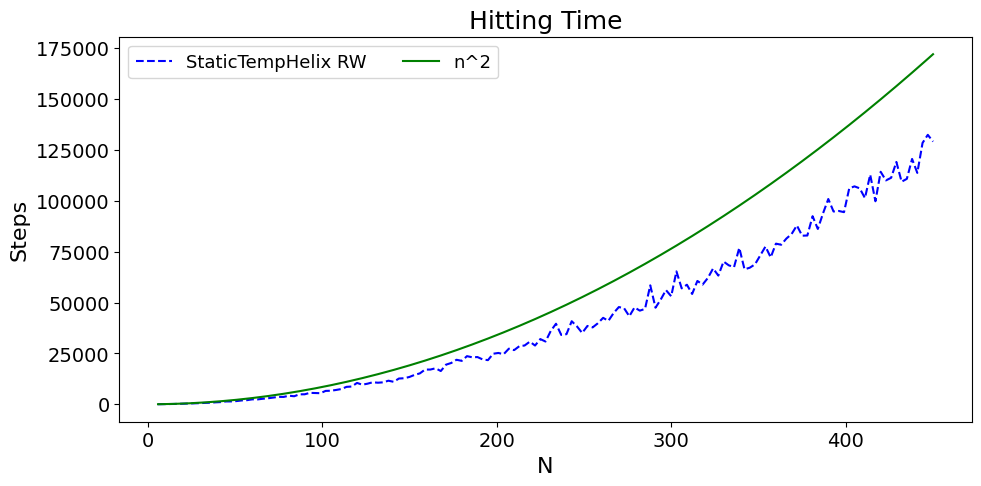

In [56]:
alphaLabelList = [r'StaticTempHelix RW',f'n^{factor}']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range),list(sum_range)] , y_value_matrix = [hitting_times,theoretical_hitting_times],**params)

## Fitting the data

In [57]:
# Assume x_data and y_data are your data
x_data = sum_range
y_data = hitting_times

# Take the logarithm of your data
log_x = np.log10(x_data)
log_y = np.log10(y_data)

# Reshape your data because sklearn requires it to be in this format
log_x = log_x.reshape(-1, 1)
log_y = log_y.reshape(-1, 1)

# Create a LinearRegression object
reg = LinearRegression()

# Fit the model to your data
reg.fit(log_x, log_y)

# Now, your value of c is:
constant = 10 ** reg.intercept_

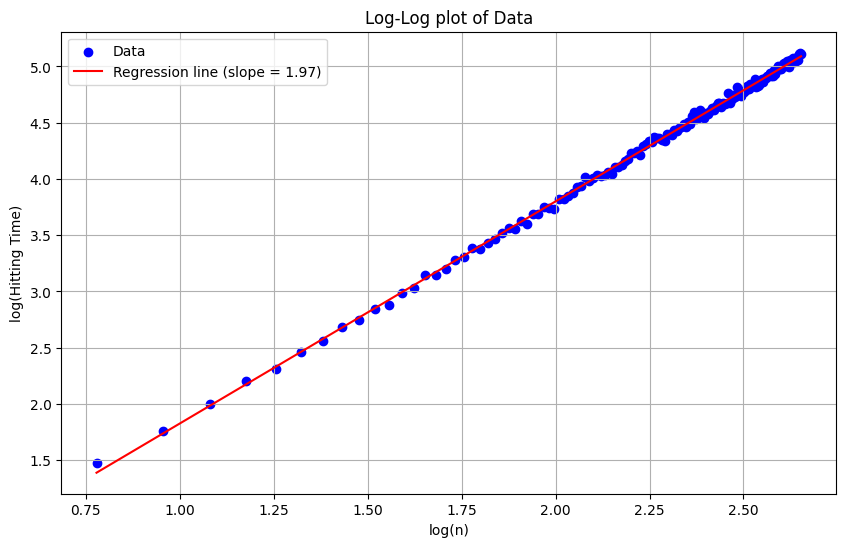

In [58]:
def plot_loglog(x_data, y_data):
    # Take the logarithm of your data
    log_x = np.log10(x_data)
    log_y = np.log10(y_data)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, color='blue', label='Data')

    # Add a regression line
    slope, intercept = np.polyfit(log_x, log_y, 1)
    plt.plot(log_x, slope*log_x + intercept, color='red', label=f'Regression line (slope = {slope:.2f})')

    # Add labels and legend
    plt.xlabel('log(n)')
    plt.ylabel('log(Hitting Time)')
    plt.title('Log-Log plot of Data')
    plt.legend()
    plt.grid(True)
    plt.show()
    return slope

# Assume x_data and y_data are your data
slope = plot_loglog(x_data, y_data)

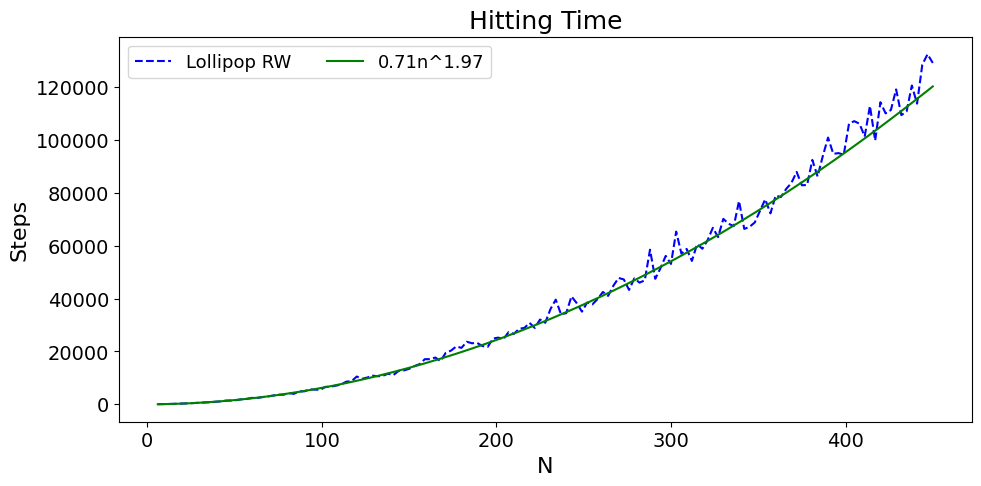

In [59]:
c = constant[0]
factor = round(slope,2)

estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]


alphaLabelList = [r'Lollipop RW',f'{round(c,2)}n^{factor}']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range),list(sum_range)] , y_value_matrix = [hitting_times,estimate_cover_time_memory],**params)

# Theoretical Hitting Time

In [60]:
from scripts_theoreticalHittingTime import create_transition_matrix,expected_hitting_time

In [63]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
def expected_hitting_time(P, q, z):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states

    # Create the modified transition matrix P_{-z}
    P_minus_z = P.copy()
    P_minus_z[:, z] = 0  # zero the column corresponding to z
    P_minus_z[z, :] = 0  # zero the row corresponding to z
    # Create the modified initial state distribution q_{-z}
    q_minus_z = q.copy()
    q_minus_z[z] = 0  # zero the element corresponding to z

    # Create the identity matrix
    I = np.eye(n)

    # Calculate the inverse of (I - P_{-z})
    inv = np.linalg.inv(I - P_minus_z)

    # Calculate the expected hitting time from state q to state z
    h_z_q = np.dot(q_minus_z, np.dot(inv, np.ones(n)))

    return h_z_q

def hitting_times_for_staticTempHelix_graphs(reps, initIndex, target):
    hitting_times = []
    for rep in range(1,reps):
            G = nx.from_numpy_array(generate_static_temporal_helix(rep))
            init = np.zeros(len(G))
            init[initIndex] = 1
            P = create_transition_matrix(G)
            hitting_time = expected_hitting_time(P, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

reps = 150

init = 0
target = -1

theoretical_hitting_times2 = hitting_times_for_staticTempHelix_graphs(reps, init, target)


[36, 81, 144, 225, 324, 441, 576, 729, 900, 1089, 1296, 1521, 1764, 2025, 2304, 2601, 2916, 3249, 3600, 3969, 4356, 4761, 5184, 5625, 6084, 6561, 7056, 7569, 8100, 8649, 9216, 9801, 10404, 11025, 11664, 12321, 12996, 13689, 14400, 15129, 15876, 16641, 17424, 18225, 19044, 19881, 20736, 21609, 22500, 23409, 24336, 25281, 26244, 27225, 28224, 29241, 30276, 31329, 32400, 33489, 34596, 35721, 36864, 38025, 39204, 40401, 41616, 42849, 44100, 45369, 46656, 47961, 49284, 50625, 51984, 53361, 54756, 56169, 57600, 59049, 60516, 62001, 63504, 65025, 66564, 68121, 69696, 71289, 72900, 74529, 76176, 77841, 79524, 81225, 82944, 84681, 86436, 88209, 90000, 91809, 93636, 95481, 97344, 99225, 101124, 103041, 104976, 106929, 108900, 110889, 112896, 114921, 116964, 119025, 121104, 123201, 125316, 127449, 129600, 131769, 133956, 136161, 138384, 140625, 142884, 145161, 147456, 149769, 152100, 154449, 156816, 159201, 161604, 164025, 166464, 168921, 171396, 173889, 176400, 178929, 181476, 184041, 186624, 18

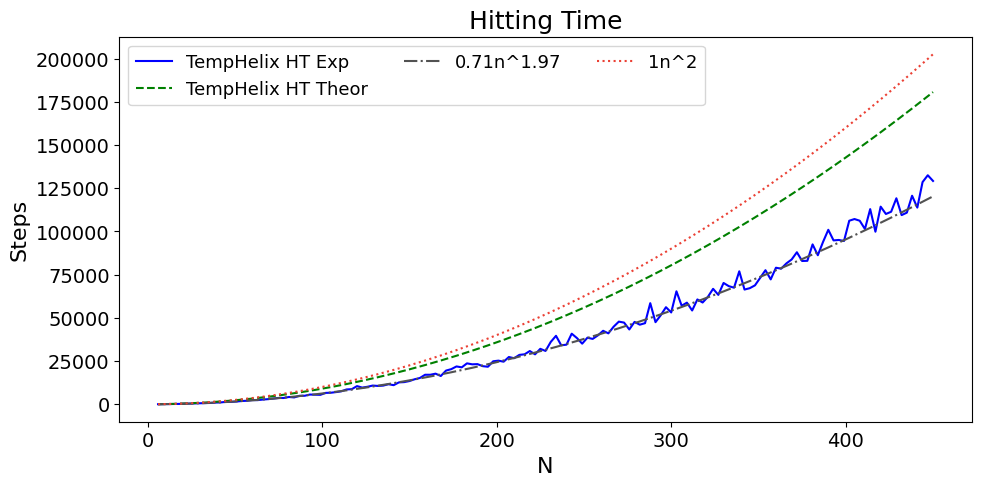

In [64]:
c = constant[0]
factor = round(slope,2)
c2 = 1
factor2 = 2

alphaLabelList = [r'TempHelix HT Exp',f'TempHelix HT Theor',f'{round(c,2)}n^{factor}',f'{round(c2,2)}n^{factor2}']



estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]
estimate_cover_time_memory2 = [x for x in theoretical_hitting_time(sum_range,factor2,c2)]
print(estimate_cover_time_memory2)
print(list(sum_range))

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034'],
    'line_style_list' : ['-', '--','-.',':' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range)]*4 , y_value_matrix = [hitting_times,theoretical_hitting_times2,estimate_cover_time_memory,estimate_cover_time_memory2],**params)